<a href="https://colab.research.google.com/github/KaanC3lik/Aygaz-Image-Processing/blob/main/goruntu_isleme_bootcamp_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rrebirrth_animals_with_attributes_2_path = kagglehub.dataset_download('rrebirrth/animals-with-attributes-2')

print('Data source import complete.')


100%|██████████| 13.0G/13.0G [02:37<00:00, 88.2MB/s]

Extracting files...


Data source import complete.


I changed the code to save the first 650 images of each animal species.

In [7]:
import os

# Initialize the dictionary to hold paths for each animal
image_paths = {}

# Base directory for your dataset
base_path = "/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/"

# List of animals to search for
animals = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

# Traverse the directory structure
for dirname, _, filenames in os.walk(base_path):
    for animal in animals:
        # Check if the current directory contains the animal's name
        if animal in dirname:
            # Initialize the list if the animal is encountered for the first time
            if animal not in image_paths:
                image_paths[animal] = []
            # Add 650 image paths for the current animal
            for filename in filenames:
                if len(image_paths[animal]) < 650:
                  image_paths[animal].append(os.path.join(dirname, filename))
                else:
                  break



# Print the paths for verification
for animal, paths in image_paths.items():
    print(f"{animal}: {len(paths)} images")

giant+panda: 650 images
elephant: 650 images
polar+bear: 650 images
rabbit: 650 images
moose: 650 images
dolphin: 650 images
squirrel: 650 images
fox: 650 images
sheep: 650 images
collie: 650 images


The load_and_preprocess_images function is designed to handle image datasets organized by categories. It takes as input a dictionary of image paths categorized by class and a target size for resizing the images. Each image is read using OpenCV, resized to a uniform shape (64x64 pixels in this case), and normalized to scale pixel values to a range of [0, 1]. Normalization improves the training process by ensuring that all pixel values have the same scale, which can help the model converge faster.

In [10]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to load and preprocess images
def load_and_preprocess_images(image_paths, image_size):
    data = []
    labels = []

    for animal, paths in image_paths.items():
        for img_path in paths:
            img = cv2.imread(img_path)

            # Normalize pixel values to the range [0, 1]
            if img is not None:
                img_resized = cv2.resize(img, image_size)
                img_normalized = img_resized / 255.0
                data.append(img_normalized)
                labels.append(animal)

    return np.array(data), np.array(labels)  # Convert lists to NumPy arrays and return

In [11]:
image_size = (64, 64)

# Load and preprocess images using the specified image paths
X, y = load_and_preprocess_images(image_paths, image_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

A LabelEncoder is then used to convert the class labels (animal names) into numerical format, with one-hot encoding.

In [41]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder to convert animal names to numerical labels
label_encoder = LabelEncoder()
label_encoder.fit(animals)

# Transform y_train and y_test to numerical labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encoding (Modelin kullanması için etiketleri dönüştür)
y_train_onehot = to_categorical(y_train_encoded, num_classes=len(animals))
y_test_onehot = to_categorical(y_test_encoded, num_classes=len(animals))


Initialized an image data generator for data augmentation.
Data augmentation is performed using the ImageDataGenerator class, which applies random transformations such as rotations, translations, zooming, and horizontal flips to enhance the diversity of the training data.

In [19]:

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Create a training data generator that applies data augmentation
batch_size = 32
train_generator = datagen.flow(X_train, y_train_onehot, batch_size=batch_size)


for X_batch, y_batch in train_generator:
    print(f"A batch produced by data augmentation: {X_batch.shape}, Labels: {y_batch.shape}")
    break

A batch produced by data augmentation: (32, 64, 64, 3), Labels: (32, 10)





*   This code defines a Convolutional Neural Network (CNN) architecture designed to classify images into 10 animal categories. The model begins with an input layer configured for images of size 64x64x3, which corresponds to RGB images.
*    The first layer is a convolutional layer with 32 filters of size 3x3, followed by a ReLU activation function to introduce non-linearity. This layer is paired with a MaxPooling layer, which reduces the spatial dimensions of the feature maps while preserving their most important features.
*   After the convolutional and pooling layers, the feature maps are flattened into a one-dimensional vector, allowing the data to pass into fully connected layers. A dense layer with 128 units and ReLU activation is used to further process the extracted features.
*   To prevent overfitting, a Dropout layer with a rate of 0.5 is applied, randomly setting half of the neurons to zero during training.

*    The final layer consists of 10 units (one for each animal class) with a softmax activation function, which converts the output into probabilities for each class.





In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (64, 64, 3) # Image size (height, width, channels)
num_classes = 10 # For classification 10 classes
conv_filters = 32 # Number of filters for convolution layers
kernel_size = (3, 3) # Size of the convolution kernel
pool_size = (2, 2) # Size of the pooling layer
dense_units = 128 # Number of units in the fully connected layer
learning_rate = 0.001 # Learning rate for the optimizer


model = Sequential()

# 1. Convolutional Layer
model.add(Conv2D(conv_filters, kernel_size, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size))  # 1. Pooling Layer

# 2. Convolutional Layer
model.add(Conv2D(conv_filters*2, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))  # 2. Pooling Layer

# 3. Convolutional Layer
model.add(Conv2D(conv_filters*3, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))  # 3. Pooling Layer

# 4. Fully Connected Layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(len(animals), activation='softmax'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3456)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         442,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 518,570 (1.98 MB)

 Trainable params: 518,570 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

*   The optimizer is set to Adam with a learning rate of 0.001.
Adam is an adaptive learning rate optimization algorithm that computes individual learning rates for each parameter, which generally leads to faster convergence.
*   Choosed Categorical cross-entropy for loss function. Because it is commonly used for multi-class classification problems where the labels are one-hot encoded



In [22]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Trained the model with augmented data in 20 epoch. Model's accuracy is 0.66

In [24]:
# Modeli eğitme
epochs = 20  # Eğitim adım sayısı (epoch)

history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test_onehot))  # Validation data kullanarak değerlendirme


Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 38s 266ms/step - accuracy: 0.4736 - loss: 1.5089 - val_accuracy: 0.5621 - val_loss: 1.2959
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5000 - loss: 1.4741 - val_accuracy: 0.5677 - val_loss: 1.2744
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 77s 267ms/step - accuracy: 0.4950 - loss: 1.4681 - val_accuracy: 0.5733 - val_loss: 1.2332
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4375 - loss: 1.5893 - val_accuracy: 0.5656 - val_loss: 1.2399
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 79s 280ms/step - accuracy: 0.4878 - loss: 1.4407 - val_accuracy: 0.5928 - val_loss: 1.2235
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5312 - loss: 1.5584 - val_accuracy: 0.5856 - val_loss: 1.2121
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.5462 - loss: 1.3583 - val_accuracy: 0.6174 - val_loss: 1.1355
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4375 - loss: 1.4246 - 

In [27]:
def linearize_image(image):
    """
    Converts an sRGB image to linear RGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.04045,
                    image / 12.92,
                    ((image + 0.055) / 1.055) ** 2.4)


def linear_to_srgb(image):
    """
    Converts a linear RGB image to sRGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.0031308,
                    image * 12.92,
                    1.055 * (image ** (1 / 2.4)) - 0.055)


def handle_saturation(image, lower=0.05, upper=0.95):
    """
    Creates a mask for non-saturated pixels (those between `lower` and `upper` thresholds)
    """
    return np.all((image > lower) & (image < upper), axis=-1)



### Color constancy
def estimate_light_source_grey_world(image, mask):
    """
    Estimates the light source based on the Grey World assumption, using valid pixels from the mask
    """
    valid_pixels = image[mask]
    avg_color = np.mean(valid_pixels, axis=0)
    return avg_color / np.linalg.norm(avg_color)


def correct_colors(image, light_source):
    """
    Corrects the colors of the image by applying white balance using the estimated light source
    """
    return image * (1.0 / light_source)


def manipulate_light_source(image, light_color):
    """
    Simulates color manipulation under a different light source

    Args:
    - image: The input image (sRGB, [0, 1])
    - light_color: The light source color (unit norm RGB vector)

    Returns:
    - Manipulated image (sRGB, [0, 1])
    """
    # Step 1: Linearize the image
    linear_image = linearize_image(image)

    # Step 2: Apply the light source (multiplying the linear image by the light color)
    manipulated_image = linear_image * light_color

    # Step 3: Convert the manipulated image back to sRGB
    manipulated_srgb = linear_to_srgb(manipulated_image)

    return np.clip(manipulated_srgb, 0, 1)


def process_and_white_balance(image):
    """
    Applies white balance using both the Grey World and Max RGB methods
    Returns both corrected images in sRGB format
    """
    linear_image = linearize_image(image)
    valid_mask = handle_saturation(linear_image)

    # Light source estimations
    grey_world_light = estimate_light_source_grey_world(linear_image, valid_mask)

    # Color correction using both light sources
    corrected_grey_world = correct_colors(linear_image, grey_world_light)

    # Convert back to sRGB
    srgb_grey_world = linear_to_srgb(corrected_grey_world)

    # Clip and return
    return np.clip(srgb_grey_world, 0, 1)


# Light sources for color manipulation
def get_light_sources():
    """
    Returns a set of light sources for image manipulation
    """
    purplish_light = np.array([0.82, 0.15, 0.89]) / np.linalg.norm([0.82, 0.15, 0.89])
    yellowish_light = np.array([0.96, 0.24, 0.11]) / np.linalg.norm([0.96, 0.24, 0.11])
    greenish_light = np.array([0.11, 0.98, 0.12]) / np.linalg.norm([0.11, 0.98, 0.12])
    return purplish_light, yellowish_light, greenish_light


def get_wb_images(image):
    """
    Process and white balance the image
    """

    srgb_grey_world = process_and_white_balance(image)

    # Save the white-balanced images
    #cv2.imwrite('white_balanced_grey_world.jpg', cv2.cvtColor((srgb_grey_world*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    return srgb_grey_world


def get_manipulated_images(image):
    """
    Get manipulated images by applying color vectors
    """

    # Get the color vectors
    purplish_light, orangish_light, greenish_light = get_light_sources()

    # Manipulate the images under different light sources
    manipulated_purplish = manipulate_light_source(image, purplish_light)
    manipulated_orangish = manipulate_light_source(image, orangish_light)
    manipulated_greenish = manipulate_light_source(image, greenish_light)

    # Save the manipulated images
    #cv2.imwrite('manipulated_purplish.jpg', cv2.cvtColor((manipulated_purplish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    #cv2.imwrite('manipulated_orangish.jpg', cv2.cvtColor((manipulated_orangish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    #cv2.imwrite('manipulated_greenish.jpg', cv2.cvtColor((manipulated_greenish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    return manipulated_purplish, manipulated_orangish, manipulated_greenish


The code manipulates the test images by applying three different color filters (purplish, orangish, and greenish) to each image in the test set. For each manipulated image, the corresponding label is repeated, and the new images are added to the test set. After manipulation, the new test set and labels are returned as NumPy array.

In [42]:
def manipulate_test_images(X_test, y_test):

    manipulated_test_set = []
    manipulated_labels = []

    for img, label in zip(X_test, y_test_onehot):
        # Get manipulated images
        manipulated_purplish, manipulated_orangish, manipulated_greenish = get_manipulated_images(img)

        # Add manipulted images in dictionary with it's labels
        manipulated_test_set.extend([manipulated_purplish, manipulated_orangish, manipulated_greenish])
        manipulated_labels.extend([label, label, label])

    return np.array(manipulated_test_set), np.array(manipulated_labels)


manipulated_test_set, manipulated_labels = manipulate_test_images(X_test, y_test)

print(f"Manipulated test set size: {manipulated_test_set.shape}")
print(f"Manipulated label size: {manipulated_labels.shape}")

Manipulated test set size: (5850, 64, 64, 3)
Manipulated label size: (5850, 10)


Evaluating new manipulated images with our model. After manipulating images our model's new accuracy is 0.16. So our model is failed at predicting animals when image color is manipulated. Model's accuracy decreased from 0.66 to 0.16.

In [37]:
# Manipulate test images
manipulated_test_set, manipulated_labels = manipulate_test_images(X_test, y_test)

# Evaluate model
loss, accuracy = model.evaluate(manipulated_test_set, manipulated_labels_onehot, verbose=1)

print(f"Manipüle edilmiş test seti üzerindeki kayıp (loss): {loss}")
print(f"Manipüle edilmiş test seti üzerindeki doğruluk (accuracy): {accuracy}")


183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.1646 - loss: 5.0438
Manipüle edilmiş test seti üzerindeki kayıp (loss): 5.03700065612793
Manipüle edilmiş test seti üzerindeki doğruluk (accuracy): 0.1688888818025589


To overcame our model's reliance on color, applied color correction. Now model's accuracy is back to it's original level 0.66. My inference is, color correciton method is crucial part of image processing.

In [38]:
def apply_color_correction(manipulated_test_set):
    corrected_images = []

    for image in manipulated_test_set:
        corrected_image = get_wb_images(image)
        corrected_images.append(corrected_image)

    return np.array(corrected_images)

# Test setindeki manipüle edilmiş resimleri renk sabitlemesi ile düzeltme
manipulated_test_corrected = apply_color_correction(manipulated_test_set)

# Modeli manipüle edilmiş test setiyle değerlendir
loss, accuracy = model.evaluate(manipulated_test_corrected, manipulated_labels_onehot, verbose=1)

# Sonuçları yazdır
print(f"Manipüle edilmiş test seti üzerindeki kayıp (loss): {loss}")
print(f"Manipüle edilmiş test seti üzerindeki doğruluk (accuracy): {accuracy}")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.6376 - loss: 1.0816
Manipüle edilmiş test seti üzerindeki kayıp (loss): 1.0614460706710815
Manipüle edilmiş test seti üzerindeki doğruluk (accuracy): 0.642393171787262


Image processing models could be sensitive to image color manipulations, and using techniques like color correction can help mitigate this issue and bring the performance back to normal.

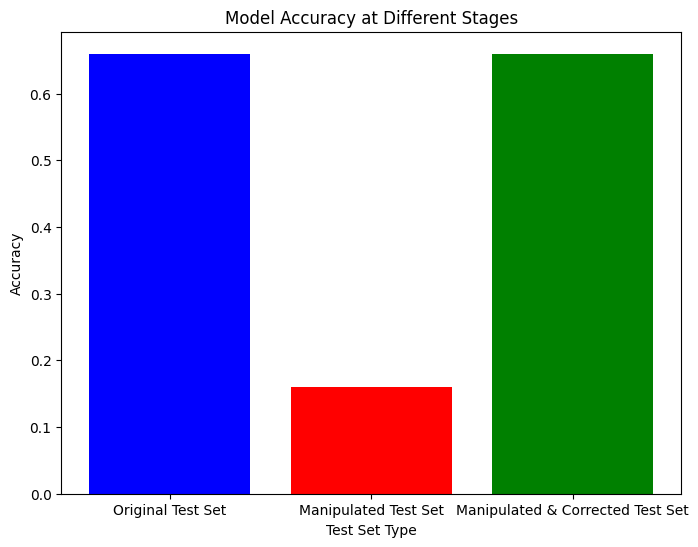

In [39]:
import matplotlib.pyplot as plt

# Accuracy values for different stages
accuracies = [0.66, 0.16, 0.66]
labels = ['Original Test Set', 'Manipulated Test Set', 'Manipulated & Corrected Test Set']

# Create a bar plot
plt.figure(figsize=(8,6))
plt.bar(labels, accuracies, color=['blue', 'red', 'green'])

# Add title and labels
plt.title('Model Accuracy at Different Stages')
plt.xlabel('Test Set Type')
plt.ylabel('Accuracy')

# Show the plot
plt.show()
